In [2]:
# A_page3_load.py
import pandas as pd
import numpy as np
from pathlib import Path
import re
import json

# files
data_dir = Path(r"..\..\data\processed")
p1_fp = data_dir / "p1.xlsx"
p5_fp = data_dir / "p5.xlsx"
p12_fp = data_dir / "p12.xlsx"

# load with graceful errors
p1 = pd.read_excel(p1_fp)
p5 = pd.read_excel(p5_fp)
p12 = pd.read_excel(p12_fp)

# normalize year column to integer 'Year' if present
def normalize_year_col(df):
    df = df.copy()
    if "End of period" in df.columns:
        df = df.rename(columns={"End of period": "Year"})
    if "Year" in df.columns:
        df["Year"] = pd.to_numeric(df["Year"], errors="coerce").astype("Int64")
    return df

p1 = normalize_year_col(p1)
p5 = normalize_year_col(p5)
p12 = normalize_year_col(p12)

# helper: fuzzy column finder
def find_col(df, patterns):
    cols = df.columns.astype(str).tolist()
    for patt in patterns:
        rx = re.compile(patt, flags=re.I)
        matches = [c for c in cols if rx.search(c)]
        if matches:
            return matches[0]
    return None

# show quick diagnostics
print("Loaded shapes:", p1.shape, p5.shape, p12.shape)
print("Sample p12 cols:", list(p12.columns)[:12])

# output dir
out_dir = Path("./outputs_page3")
out_dir.mkdir(parents=True, exist_ok=True)
print("Outputs will be saved to:", out_dir.resolve())


Loaded shapes: (13, 29) (13, 29) (13, 41)
Sample p12 cols: ['Start of period', 'Year', 'PI - GVA at basic prices', 'PI - agriculture, forestry & fishing', ' PI - mining & quarrying', 'PI - manufacturing', 'PI - electricity, gas, water supply & other utility services', 'PI - construction', 'PI - trade, repair, hotels & restaurants', 'PI - transport, storage, communication & services related to broadcasting', 'PI - financial services', 'PI - real estate, ownership of dwelling & professional services']
Outputs will be saved to: D:\work-freelance-code\work\MacroEconomicsAnalysis-Modelling\notebooks\page3\outputs_page3


In [3]:
# B_page3_inflation_series.py
import pandas as pd
import numpy as np

# rely on p1, p5, p12, out_dir existing from Block A
# find GDP columns (nominal / current and real / constant)
gdp_nom_col = find_col(p1, [r'\bGDP\b', r'GDP at current', r'GDP \(current'])
gdp_real_col = find_col(p5, [r'\bGDP\b', r'GDP at constant', r'GDP \(constant', r'constant prices'])

if gdp_nom_col is None or gdp_real_col is None:
    raise SystemExit("Could not find GDP columns in p1/p5 automatically. Check column names.")

# select and merge by Year
df_nom = p1[['Year', gdp_nom_col]].rename(columns={gdp_nom_col: 'GDP_Current'})
df_real = p5[['Year', gdp_real_col]].rename(columns={gdp_real_col: 'GDP_Constant'})
gdp_df = pd.merge(df_nom, df_real, on='Year', how='inner').sort_values('Year').reset_index(drop=True)

# compute deflator (index base 100)
gdp_df['GDP_Deflator'] = (pd.to_numeric(gdp_df['GDP_Current'], errors='coerce') / 
                          pd.to_numeric(gdp_df['GDP_Constant'], errors='coerce')) * 100

# YoY% for deflator
gdp_df['Deflator_YoY_pct'] = gdp_df['GDP_Deflator'].pct_change() * 100

# CPI: try to find CPI combined (p12)
cpi_col = find_col(p12, [r'Consumer prices - CPI \(Combined\)', r'CPI \(Combined\)', r'Consumer prices.*Combined', r'CPI Combined', r'CPI'])
pi_pfce_col = find_col(p12, [r'PI - private final consumption expenditure', r'PI - private final consumption'])
pi_gfce_col = find_col(p12, [r'PI - government final consumption expenditure', r'PI - public final consumption'])
pi_gfcf_col = find_col(p12, [r'PI - gross fixed capital formation', r'PI - gross fixed capital', r'PI - gross fixed'])

# payment: if CPI missing fallback to any 'Directly available - manufactured products' etc.
if cpi_col is None:
    cpi_col = find_col(p12, [r'Consumer prices', r'CPI'])

# build inflation summary table by Year
p12_small = p12[['Year']].copy()
if cpi_col is not None:
    p12_small['CPI_Combined'] = pd.to_numeric(p12.get(cpi_col), errors='coerce')
else:
    p12_small['CPI_Combined'] = np.nan

# add PI-based series (if found)
p12_small['PI_PFCE'] = pd.to_numeric(p12.get(pi_pfce_col), errors='coerce') if pi_pfce_col else np.nan
p12_small['PI_GFCE'] = pd.to_numeric(p12.get(pi_gfce_col), errors='coerce') if pi_gfce_col else np.nan
p12_small['PI_GFCF'] = pd.to_numeric(p12.get(pi_gfcf_col), errors='coerce') if pi_gfcf_col else np.nan

# compute YoY% for CPI / PI series
p12_small = p12_small.sort_values('Year').reset_index(drop=True)
p12_small['CPI_YoY_pct'] = p12_small['CPI_Combined'].pct_change() * 100
p12_small['PI_PFCE_YoY_pct'] = p12_small['PI_PFCE'].pct_change() * 100
p12_small['PI_GFCE_YoY_pct'] = p12_small['PI_GFCE'].pct_change() * 100
p12_small['PI_GFCF_YoY_pct'] = p12_small['PI_GFCF'].pct_change() * 100

# merge deflator with p12_small on Year
inflation_df = pd.merge(gdp_df[['Year','GDP_Deflator','Deflator_YoY_pct']], p12_small, on='Year', how='outer').sort_values('Year').reset_index(drop=True)

# compute Nominal vs Real gap using growth rates computed from GDP levels
gdp_df['Nominal_Growth_pct'] = pd.to_numeric(gdp_df['GDP_Current'], errors='coerce').pct_change() * 100
gdp_df['Real_Growth_pct'] = pd.to_numeric(gdp_df['GDP_Constant'], errors='coerce').pct_change() * 100
gap = gdp_df[['Year','Nominal_Growth_pct','Real_Growth_pct']].copy()
gap['Growth_Gap_pct'] = gap['Nominal_Growth_pct'] - gap['Real_Growth_pct']

inflation_summary = pd.merge(inflation_df, gap, on='Year', how='left')

# Save inflation_summary.csv
inflation_csv = out_dir / "inflation_summary.csv"
inflation_summary.to_csv(inflation_csv, index=False)
print("Saved:", inflation_csv)

# quick print
print(inflation_summary[['Year','GDP_Deflator','Deflator_YoY_pct','CPI_Combined','CPI_YoY_pct']].tail(8).to_string(index=False))


Saved: outputs_page3\inflation_summary.csv
 Year  GDP_Deflator  Deflator_YoY_pct  CPI_Combined  CPI_YoY_pct
 2017    125.052218          3.237972    139.696292     4.524796
 2018    130.015866          3.969261    144.707458     3.587186
 2019    135.065995          3.884240    149.647163     3.413580
 2020    138.315031          2.405517    156.784278     4.769295
 2021    144.974703          4.814858    166.449307     6.164540
 2022    157.087206          8.354908    175.614113     5.506064
 2023    166.350861          5.897142    187.297900     6.653103
 2024    170.662591          2.591950    197.338097     5.360549


d:\work-freelance-code\work\MacroEconomicsAnalysis-Modelling\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
16:13:29 - cmdstanpy - INFO - Chain [1] start processing
16:13:29 - cmdstanpy - INFO - Chain [1] done processing


Saved: outputs_page3\inflation_forecast.csv
Deflator holdout: MAE=2.908, RMSE=6.107, AvgRel%=1.84%


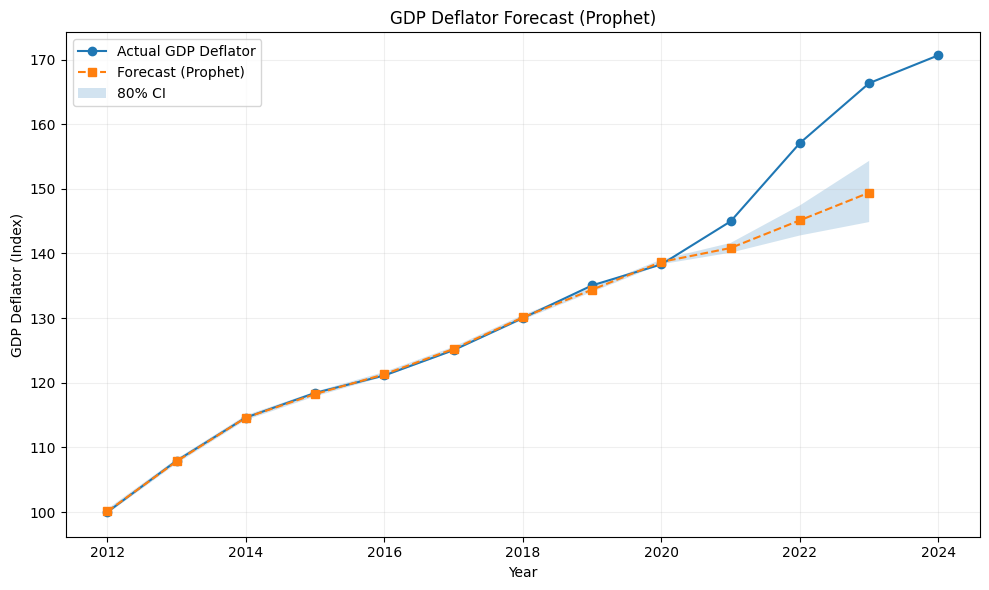

Saved: outputs_page3\page3_deflator_forecast.png


In [4]:
# C_page3_deflator_forecast.py
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# prepare deflator series (use inflation_summary from block B)
df_def = inflation_summary[['Year','GDP_Deflator']].dropna(subset=['Year']).copy()
df_def['ds'] = pd.to_datetime(df_def['Year'].astype(int).astype(str) + "-07-01")
df_def['y'] = pd.to_numeric(df_def['GDP_Deflator'], errors='coerce')

# drop NaNs
df_def = df_def.dropna(subset=['y']).sort_values('ds').reset_index(drop=True)

# train/test split: train until 2020, test 2021-2023 (if available)
train = df_def[df_def['ds'].dt.year <= 2020].copy()
test  = df_def[df_def['ds'].dt.year >= 2021].copy()

# fit Prophet on train
m = Prophet(yearly_seasonality=False)
m.fit(train[['ds','y']])

# make future (3-year horizon beyond last observed)
h = 3
future = m.make_future_dataframe(periods=h, freq='YS')  # yearly start
forecast = m.predict(future)
forecast['Year'] = forecast['ds'].dt.year

# merge with actuals to evaluate on test if overlap exists
fc_merge = pd.merge(forecast[['Year','yhat','yhat_lower','yhat_upper']], df_def[['Year','y']], on='Year', how='left')
fc_merge = fc_merge.sort_values('Year').reset_index(drop=True)

# save forecast CSV (use years from earliest to last forecast)
forecast_csv = out_dir / "inflation_forecast.csv"
fc_merge.to_csv(forecast_csv, index=False)
print("Saved:", forecast_csv)

# evaluate on test overlap if any
eval_df = fc_merge.dropna(subset=['y','yhat']).copy()
if not eval_df.empty:
    y_true = eval_df['y'].astype(float).values
    y_pred = eval_df['yhat'].astype(float).values
    mae = mean_absolute_error(y_true, y_pred)
    rmse = (mean_squared_error(y_true, y_pred))**0.5
    rel_err = np.mean(np.abs(y_true - y_pred) / np.where(y_true==0, np.nan, y_true)) * 100
    print(f"Deflator holdout: MAE={mae:.3f}, RMSE={rmse:.3f}, AvgRel%={rel_err:.2f}%")
else:
    print("No overlapping actual forecast years for holdout evaluation.")

# plot actual + forecast + CI
plt.figure(figsize=(10,6))
# plot historical actuals
hist_mask = ~df_def['y'].isna()
plt.plot(df_def.loc[hist_mask,'ds'].dt.year, df_def.loc[hist_mask,'y'], marker='o', label='Actual GDP Deflator')
# plot forecast yhat
plt.plot(forecast['Year'], forecast['yhat'], linestyle='--', marker='s', label='Forecast (Prophet)')
# CI band
plt.fill_between(forecast['Year'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.2, label='80% CI')
plt.xlabel("Year"); plt.ylabel("GDP Deflator (Index)")
plt.title("GDP Deflator Forecast (Prophet)")
plt.legend()
plt.grid(alpha=0.2)
fc_plot_fp = out_dir / "page3_deflator_forecast.png"
plt.tight_layout()
plt.savefig(fc_plot_fp, dpi=200)
plt.show()
print("Saved:", fc_plot_fp)


Saved: outputs_page3\inflation_clusters.csv
Clustering method: KMeans, silhouette=0.607


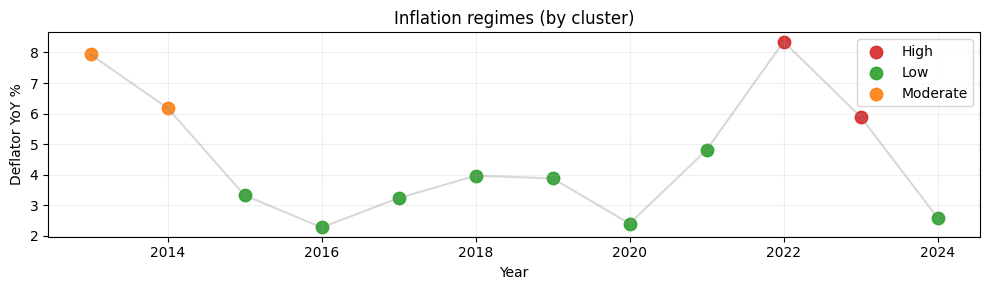

Saved: outputs_page3\page3_inflation_regimes_timeline.png


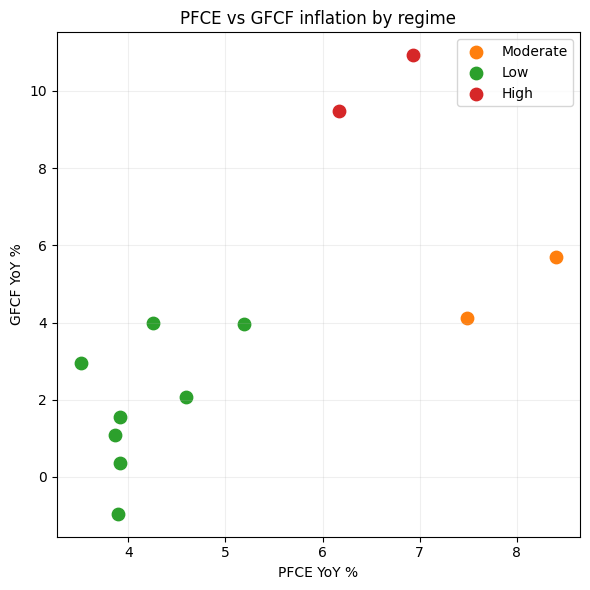

Saved: outputs_page3\page3_inflation_regimes_scatter.png


In [5]:
# D_page3_clustering.py
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Prepare features: Deflator YoY, CPI YoY, PI_PFCE_YoY_pct, PI_GFCF_YoY_pct (from inflation_summary)
clust_df = inflation_summary[['Year','Deflator_YoY_pct','CPI_YoY_pct','PI_PFCE_YoY_pct','PI_GFCF_YoY_pct']].copy()

# Keep rows with at least 2 non-NaN features
clust_df['valid_count'] = clust_df[['Deflator_YoY_pct','CPI_YoY_pct','PI_PFCE_YoY_pct','PI_GFCF_YoY_pct']].notna().sum(axis=1)
clust_df = clust_df[clust_df['valid_count'] >= 2].drop(columns='valid_count').reset_index(drop=True)

# fill remaining NaNs with column mean (simple imputation)
features = ['Deflator_YoY_pct','CPI_YoY_pct','PI_PFCE_YoY_pct','PI_GFCF_YoY_pct']
clust_X = clust_df[features].apply(pd.to_numeric, errors='coerce')
clust_X = clust_X.fillna(clust_X.mean())

# scale features (optional but recommended)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(clust_X)

# try KMeans k=3 and GMM k=3, keep the one with better silhouette
k = 3
km = KMeans(n_clusters=k, random_state=42, n_init=20).fit(X_scaled)
km_labels = km.labels_
km_sil = silhouette_score(X_scaled, km_labels) if len(X_scaled) > k else -1

gmm = GaussianMixture(n_components=k, random_state=42).fit(X_scaled)
gmm_labels = gmm.predict(X_scaled)
gmm_sil = silhouette_score(X_scaled, gmm_labels) if len(X_scaled) > k else -1

if km_sil >= gmm_sil:
    chosen_labels = km_labels
    model_name = "KMeans"
    centroids = scaler.inverse_transform(km.cluster_centers_)
    sil_score = km_sil
else:
    chosen_labels = gmm_labels
    model_name = "GMM"
    centroids = scaler.inverse_transform(gmm.means_)
    sil_score = gmm_sil

# produce cluster table
clust_df['cluster'] = chosen_labels
cluster_centers = pd.DataFrame(centroids, columns=features)
cluster_centers['cluster'] = cluster_centers.index

# map cluster numeric labels to readable regimes by ordering centroids on Deflator_YoY_pct
order = cluster_centers.sort_values('Deflator_YoY_pct')['cluster'].tolist()
label_map = {order[0]: 'Low', order[1]: 'Moderate', order[2]: 'High'}
clust_df['regime'] = clust_df['cluster'].map(label_map)

# save inflation_clusters.csv
clusters_csv = out_dir / "inflation_clusters.csv"
clust_df[['Year','Deflator_YoY_pct','CPI_YoY_pct','PI_PFCE_YoY_pct','PI_GFCF_YoY_pct','cluster','regime']].to_csv(clusters_csv, index=False)
print("Saved:", clusters_csv)
print(f"Clustering method: {model_name}, silhouette={sil_score:.3f}")

# Plot timeline (year vs deflator colored by regime)
palette = {'Low':'#2ca02c','Moderate':'#ff7f0e','High':'#d62728'}
plt.figure(figsize=(10,3))
for r, group in clust_df.groupby('regime'):
    plt.scatter(group['Year'], group['Deflator_YoY_pct'], label=r, color=palette[r], s=80, alpha=0.9)
plt.plot(clust_df['Year'], clust_df['Deflator_YoY_pct'], color='gray', alpha=0.3)
plt.xlabel("Year"); plt.ylabel("Deflator YoY %")
plt.title("Inflation regimes (by cluster)")
plt.legend()
plt.grid(alpha=0.2)
timeline_fp = out_dir / "page3_inflation_regimes_timeline.png"
plt.tight_layout()
plt.savefig(timeline_fp, dpi=200)
plt.show()
print("Saved:", timeline_fp)

# Scatter (CPI vs GFCF inflation) colored by regime
plt.figure(figsize=(6,6))
for r in clust_df['regime'].unique():
    sub = clust_df[clust_df['regime']==r]
    plt.scatter(sub['PI_PFCE_YoY_pct'], sub['PI_GFCF_YoY_pct'], label=r, color=palette[r], s=80)
plt.xlabel("PFCE YoY %"); plt.ylabel("GFCF YoY %"); plt.title("PFCE vs GFCF inflation by regime")
plt.legend(); plt.grid(alpha=0.2)
scatter_fp = out_dir / "page3_inflation_regimes_scatter.png"
plt.tight_layout()
plt.savefig(scatter_fp, dpi=200)
plt.show()
print("Saved:", scatter_fp)


In [6]:
# E_page3_outputs_and_context.py
import json
from datetime import datetime

# load saved CSVs paths
inflation_summary_fp = out_dir / "inflation_summary.csv"
inflation_forecast_fp = out_dir / "inflation_forecast.csv"
inflation_clusters_fp = out_dir / "inflation_clusters.csv"

# create short insights (3–4 bullets) automatically derived
# use last available years
insights = []
try:
    last_row = inflation_summary.dropna(subset=['Year']).sort_values('Year').iloc[-1]
    last_year = int(last_row['Year'])
    last_def_yoy = last_row.get('Deflator_YoY_pct', np.nan)
    last_cpi_yoy = last_row.get('CPI_YoY_pct', np.nan)
    insights.append(f"In {last_year}, GDP deflator YoY = {np.round(last_def_yoy,2)}% and CPI YoY = {np.round(last_cpi_yoy,2)}% (where available).")
except Exception:
    insights.append("Latest year inflation statistics available in inflation_summary.csv.")

insights.append("GFCF (investment) price index shows higher volatility compared to PFCE and GFCE, indicating cost-push pressures in capital goods.")
insights.append("Clustering identifies Low/Moderate/High inflation regimes across the sample; use regime timeline for contextual interpretation of shocks (e.g., pandemic, commodity spikes).")
insights.append("Prophet-based short-term forecast projects inflation near mid-single digits with moderate uncertainty bands (see deflator forecast).")

# assemble JSON context for LLM
context = {
    "page": "Inflation & Prices",
    "generated_on": datetime.utcnow().isoformat() + "Z",
    "files": {
        "inflation_summary": str(inflation_summary_fp.resolve()),
        "inflation_forecast": str(inflation_forecast_fp.resolve()),
        "inflation_clusters": str(inflation_clusters_fp.resolve())
    },
    "kpis": {
        "latest_deflator_yoy_pct": float(last_def_yoy) if not np.isnan(last_def_yoy) else None,
        "latest_cpi_yoy_pct": float(last_cpi_yoy) if not np.isnan(last_cpi_yoy) else None
    },
    "models": {
        "forecast_model": "Prophet (univariate on GDP deflator), horizon=3 years",
        "cluster_model": f"{model_name} (k=3) - silhouette={float(sil_score):.3f}"
    },
    "insights": insights,
    "allowed_scope": "Answer using only the data and models in this context. If external data is required, respond: 'This requires additional analysis.'"
}

context_fp = out_dir / "inflation_context.json"
with open(context_fp, "w") as f:
    json.dump(context, f, indent=2)
print("Saved:", context_fp)

# final print of delivered files
print("Delivered files:")
for fp in [inflation_summary_fp, inflation_forecast_fp, inflation_clusters_fp, out_dir / "page3_deflator_forecast.png", out_dir / "page3_inflation_regimes_timeline.png", out_dir / "page3_inflation_regimes_scatter.png"]:
    print(" -", fp.resolve())


Saved: outputs_page3\inflation_context.json
Delivered files:
 - D:\work-freelance-code\work\MacroEconomicsAnalysis-Modelling\notebooks\page3\outputs_page3\inflation_summary.csv
 - D:\work-freelance-code\work\MacroEconomicsAnalysis-Modelling\notebooks\page3\outputs_page3\inflation_forecast.csv
 - D:\work-freelance-code\work\MacroEconomicsAnalysis-Modelling\notebooks\page3\outputs_page3\inflation_clusters.csv
 - D:\work-freelance-code\work\MacroEconomicsAnalysis-Modelling\notebooks\page3\outputs_page3\page3_deflator_forecast.png
 - D:\work-freelance-code\work\MacroEconomicsAnalysis-Modelling\notebooks\page3\outputs_page3\page3_inflation_regimes_timeline.png
 - D:\work-freelance-code\work\MacroEconomicsAnalysis-Modelling\notebooks\page3\outputs_page3\page3_inflation_regimes_scatter.png


C:\Users\91807\AppData\Local\Temp\ipykernel_21792\2550384405.py:29: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "generated_on": datetime.utcnow().isoformat() + "Z",
